<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/MARLMOT/MARLMOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MARLMOT**

This notebook contains a basic MARLMOT implementation. The base tracker will be SORT and Multi-Agent Policy Parameterized by a Neural Network will be used to manage each track.

The Policy will be trained on the MOT 2015 challenge

In [1]:
!wget https://motchallenge.net/data/MOT15.zip

--2023-03-18 18:23:07--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1.2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1.22G  11.0MB/s    in 2m 2s   

2023-03-18 18:25:10 (10.2 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



In [2]:
!jar xf MOT15.zip

In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [4]:
TRAIN_FOLDERS = r"/content/MOT15/train"
TRAIN_NAMES = next(iter(os.walk(TRAIN_FOLDERS)))[1]
TRAIN_NAMES

['ADL-Rundle-6',
 'PETS09-S2L1',
 'ETH-Sunnyday',
 'TUD-Campus',
 'KITTI-13',
 'TUD-Stadtmitte',
 'ADL-Rundle-8',
 'KITTI-17',
 'Venice-2',
 'ETH-Bahnhof',
 'ETH-Pedcross2']

In [5]:
GT_COLS = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height"]

In [6]:
train_folder = os.path.join(TRAIN_FOLDERS, TRAIN_NAMES[0])
gt = pd.read_csv(os.path.join(train_folder, "gt/gt.txt"), usecols=[0,1,2,3,4,5], 
                 header=None)
gt.columns = GT_COLS
gt.head()

,frame,id,bb_left,bb_top,bb_width,bb_height
0,1,1,1703,385,157,339
1,1,3,1293,455,83,213
2,1,4,259,449,101,261
3,1,5,1253,529,55,127
4,2,1,1699,383,159,341


In [7]:
def get_color(idx):
    """ Converts an index to a color
        """
    blue = idx*30 % 256
    green = idx*103 % 256
    red = idx*50 % 256
    return (red, green, blue)
  

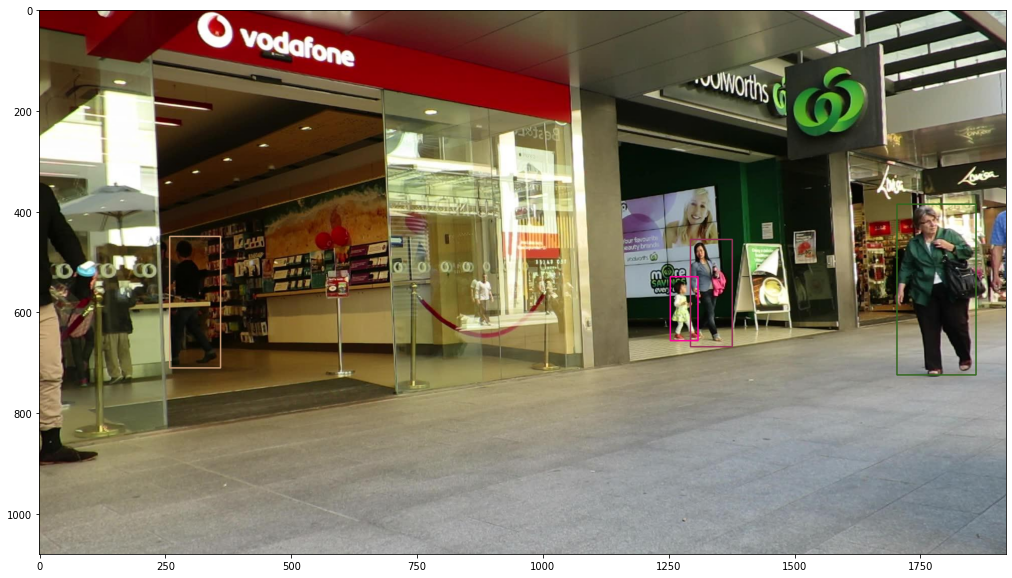

In [8]:
train_images = sorted(glob(os.path.join(train_folder, "**/*.jpg")))

# get current frame
idx = 0
current_tracks = gt.loc[gt.frame == (idx + 1), :]
frame = cv2.cvtColor(cv2.imread(train_images[idx]), cv2.COLOR_BGR2RGB)

# draw ground truth on frame
for id in current_tracks.id:
    track = current_tracks[current_tracks.id == id]

    color = get_color(id)

    pt1 = track.iloc[0, 2:4].to_numpy().astype(int)
    pt2 = pt1 + track.iloc[0, 4:6].to_numpy().round().astype(int)
    frame = cv2.rectangle(frame, pt1, pt2, color, 2)


# display frame
plt.imshow(frame)



###Get YOLOv8

In [ ]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -r requirements.txt

In [ ]:
%cd ..
!pip install ultralytics

In [ ]:
!pip install filterpy

import SORT

In [ ]:
!wget https://raw.githubusercontent.com/itberrios/CV_tracking/main/SORT/sort.py
# !wget https://raw.githubusercontent.com/abewley/sort/master/sort.py # OG SORT
from sort import *

Import YOLO model and define detection function

In [12]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

In [13]:
def get_detections(model, frame, conf=0.25):
    """ Obtains object detections from a single frame
        Inputs:
            model - YOLOv8 model object
            frame - RGB frame for detection
        Outputs:
            detections - array containing all detections and classes
                [[x1,y1,x2,y2,cls],...]
        NOTE: can modify this to obtain detections for batches of frames
        """
    # can also process multiple frames at once
    results = model(source=frame, stream=True, conf=conf, nms=True, 
                    iou=0.5, verbose=False)

    for result in results:
        xyxy = result.boxes.xyxy.cpu().numpy()
        cls = result.boxes.cls.cpu().numpy()

    return np.hstack((xyxy, np.c_[cls])).astype(int)

     


Get MSCOCO classes

In [18]:
!ls

bin	 etc	libx32			  proc	       sbin	tools
boot	 home	media			  __pycache__  sort.py	usr
content  lib	mnt			  python-apt   srv	var
datalab  lib32	NGC-DL-CONTAINER-LICENSE  root	       sys	yolov8n.pt
dev	 lib64	opt			  run	       tmp


In [21]:

import yaml

# coco_fp = r"/content/ultralytics/ultralytics/datasets/coco.yaml"
coco_fp = r"/ultralytics/ultralytics/datasets/coco.yaml"
with open(coco_fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = coco_info['names']

Run tracker on frames

In [22]:
tracker = Sort(max_age=3, min_hits=1, iou_threshold=0.3)


result_frames = []
all_tracks = []
for fpath in train_images:
    frame = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    detections = get_detections(model, frame)

    current_tracks = tracker.update(detections)
    all_tracks.append(current_tracks)

    # draw track info on frames
    for trk in current_tracks:
        pt1 = trk[0:2].astype(int)
        pt2 = trk[2:4].astype(int)

        # get color from track id (it looks better this way)
        color = get_color(trk[4])
        # class and track id
        label = str(classes[int(trk[5])] + '_' + str(int(trk[4])))

        frame = cv2.rectangle(frame, pt1, pt2, color, 2)
        frame = cv2.putText(frame, label, (pt1 + 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, 
                            color, thickness=2)

    # save results
    result_frames.append(frame)

In [161]:
all_tracks[0]

array([[        557,         395,         620,         510,          11,           0],
       [       1796,         483,        1876,         579,          10,          26],
       [       1888,         382,        1919,         577,           9,           0],
       [       1775,         434,        1874,         721,           8,           0],
       [       1419,         527,        1493,         634,           7,          56],
       [       1694,         397,        1804,         729,           6,           0],
       [       1254,         534,        1315,         655,           5,           0],
       [        113,         490,         206,         748,           4,           0],
       [       1291,         460,        1360,         656,           3,           0],
       [        255,         457,         356,         706,           2,           0],
       [          0,         315,         116,         903,           1,           0]])

In [93]:
frame_tracks = all_tracks[100] 
frame_tracks = np.round(frame_tracks[frame_tracks[:,-1] == 0][:, :4]).astype(int) # only get bboxes of person tracks
frame_tracks


array([[1604,  226, 1834,  885],
       [1369,  323, 1571,  870],
       [1074,  333, 1234,  741],
       [ 471,  426,  575,  709],
       [ 327,  450,  421,  711],
       [ 116,  525,  192,  745],
       [1317,  539, 1363,  667]])

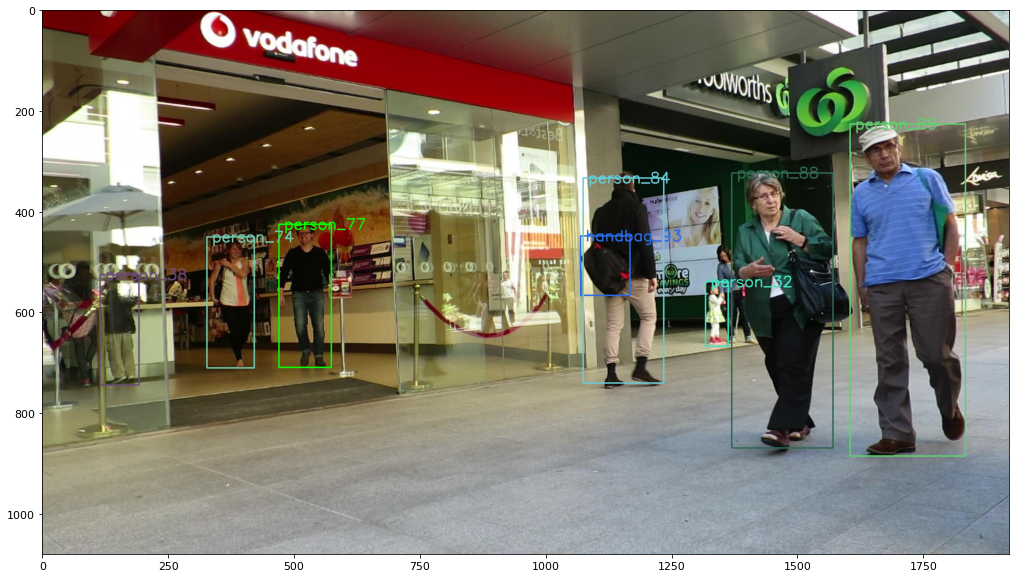

In [85]:
plt.imshow(result_frames[100])

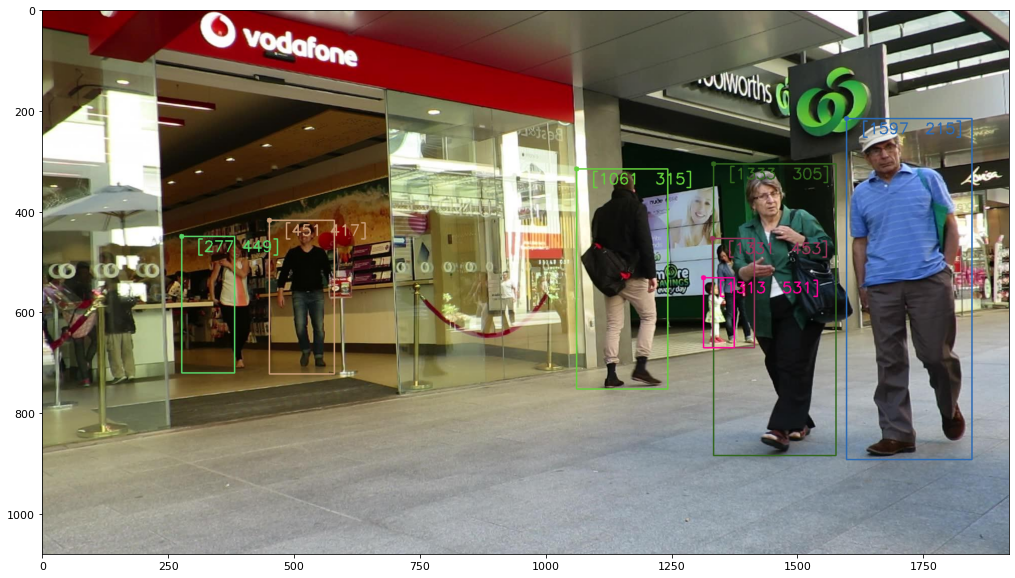

In [121]:
# get current frame
idx = 100
current_tracks = gt.loc[gt.frame == (idx + 1), :]
frame = cv2.cvtColor(cv2.imread(train_images[idx]), cv2.COLOR_BGR2RGB)

gt_bbox = []

# draw ground truth on frame
for id in current_tracks.id:
    track = current_tracks[current_tracks.id == id]

    color = get_color(id)

    pt1 = track.iloc[0, 2:4].to_numpy().astype(int)
    pt2 = pt1 + track.iloc[0, 4:6].to_numpy().round().astype(int)
    frame = cv2.rectangle(frame, pt1, pt2, color, 2)

    cv2.circle(frame, pt1, 5, color, -1)

    frame = cv2.putText(frame, str(pt1), (pt1 + 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        color, thickness=2)

    # print(pt1, pt2)
    gt_bbox.append([pt1[0], pt1[1], pt2[0], pt2[1]])


# convert to array
gt_bbox = np.array(gt_bbox)

# display frame
plt.imshow(frame)

Compare Ground Truth to Tracklets

In [117]:
gt_bbox

array([[1333,  305, 1576,  884],
       [1061,  315, 1242,  752],
       [1331,  453, 1414,  670],
       [ 451,  417,  580,  722],
       [1313,  531, 1374,  670],
       [1597,  215, 1846,  892],
       [ 277,  449,  382,  720]])

In [116]:
frame_tracks

array([[1604,  226, 1834,  885],
       [1369,  323, 1571,  870],
       [1074,  333, 1234,  741],
       [ 471,  426,  575,  709],
       [ 327,  450,  421,  711],
       [ 116,  525,  192,  745],
       [1317,  539, 1363,  667]])

Perform Hungarian Matching on tracks from tracker and Ground Truth

In [155]:
matches, false_positives, missed_tracks = \
            associate(gt_bbox, frame_tracks, thresh=1e-6)

In [123]:
matches

array([[0, 1],
       [1, 2],
       [3, 3],
       [4, 6],
       [5, 0],
       [6, 4]])

In [160]:
false_positives

[5]

In [126]:
missed_tracks

[2]

Save all tracks for future usage

In [133]:
frame_arr = np.arange(0, len(all_tracks))

In [136]:
all_tracks[0]

array([[        557,         395,         620,         510,          11,           0],
       [       1796,         483,        1876,         579,          10,          26],
       [       1888,         382,        1919,         577,           9,           0],
       [       1775,         434,        1874,         721,           8,           0],
       [       1419,         527,        1493,         634,           7,          56],
       [       1694,         397,        1804,         729,           6,           0],
       [       1254,         534,        1315,         655,           5,           0],
       [        113,         490,         206,         748,           4,           0],
       [       1291,         460,        1360,         656,           3,           0],
       [        255,         457,         356,         706,           2,           0],
       [          0,         315,         116,         903,           1,           0]])

In [144]:
all_tracks_2 = []

for i in range(len(all_tracks)):
    all_tracks_2.append(np.hstack((np.ones((len(all_tracks[i]), 1))*i, all_tracks[i])))

In [157]:
df = pd.DataFrame(np.vstack(all_tracks_2))
df.columns = ["frame", "x1", "y1", "x2", "y2", "id", "cat"]
df.head()

,frame,x1,y1,x2,y2,id,cat
0,0.0,557.0,395.0,620.0,510.0,11.0,0.0
1,0.0,1796.0,483.0,1876.0,579.0,10.0,26.0
2,0.0,1888.0,382.0,1919.0,577.0,9.0,0.0
3,0.0,1775.0,434.0,1874.0,721.0,8.0,0.0
4,0.0,1419.0,527.0,1493.0,634.0,7.0,56.0


In [158]:
train_images[0]

'/content/MOT15/train/ADL-Rundle-6/img1/000001.jpg'

In [159]:
df.to_csv("ADL-Rundle-6_SORT_tracks.csv")

Use the match and missed tracks arrays to assign tracklet and ground truth to each agent


Each Ground Truth Track has an ID the Trackers also have IDs. The IDs should never cross, if they do that is a mismatch error. The agents could possibly keep track of which ground truth IDs are associated (or just the previous ground truth ID. If the new ground truth ID is different, then there is a mismatch error. It's possible that the tracker was wrong the entire time, so we will only conisder mismatch errors between single frames. i.e. if there is a single track switch then we only count it as a single mismatch error.

